In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt 
import sys
import torch
import torch.optim as optim
import torch.nn as nn
from dip import EncDec
from utils import imread

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, UpSampling1D, Conv2DTranspose, MaxPool1D, Dropout, Conv1D, Conv2D, Conv3D, Flatten, MaxPool2D, AveragePooling2D, BatchNormalization

In [2]:
im = imread('../data/denoising/lena.png')
noise1 = imread('../data/denoising/lena-noisy.png')
error1 = ((im - noise1)**2).sum()
print ('Noisy image SE: {:.2f}'.format(error1))

Noisy image SE: 338.54


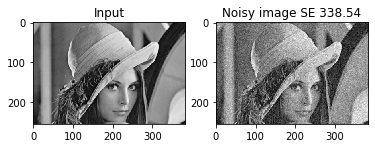

In [3]:
plt.figure(1)

plt.subplot(121)
plt.imshow(im, cmap='gray')
plt.title('Input')

plt.subplot(122)
plt.imshow(noise1, cmap='gray')
plt.title('Noisy image SE {:.2f}'.format(error1))

plt.show(block=False)

In [12]:
class EncDec(nn.Module):
    def __init__(self):
        super(EncDec, self).__init__()
        self.bn16 = nn.BatchNorm2d(16)
        self.bn32 = nn.BatchNorm2d(32)
        self.bn64 = nn.BatchNorm2d(64)
        self.bn128 = nn.BatchNorm2d(128)
        self.bn256 = nn.BatchNorm2d(256)
        
        self.conv1 = nn.Conv2d(1, 16, 3, 2, 1) # Encoder - 1
        self.conv2 = nn.Conv2d(16, 32, 3, 2, 1) # Encoder - 2
        self.conv3 = nn.Conv2d(32, 64, 3, 2, 1) # Encoder - 3 
        self.conv4 = nn.Conv2d(64, 128, 3, 2, 1) # Encoder - 4
        self.conv5 = nn.Conv2d(128, 256, 3, 2, 1) # Encoder - 5
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv5_t = nn.Conv2d(256, 256, 3, 1, 1) # Decoder - 5
        self.conv4_t = nn.Conv2d(256, 128, 3, 1, 1) # Decoder - 4
        self.conv3_t = nn.Conv2d(128, 64, 3, 1, 1) # Decoder - 3
        self.conv2_t = nn.Conv2d(64, 32, 3, 1, 1) # Decoder - 2
        self.conv1_t = nn.Conv2d(32, 16, 3, 1, 1) # Decoder - 1
        self.conv0_t = nn.Conv2d(16, 1, 3, 1, 1) # Final Decoder
        
    def forward(self, x):
        out = self.bn16(F.relu(self.conv1(x)))
        out = self.bn32(F.relu(self.conv2(out)))
        out = self.bn64(F.relu(self.conv3(out)))
        out = self.bn128(F.relu(self.conv4(out)))
        out = self.bn256(F.relu(self.conv5(out)))
        out = self.upsample(self.bn256(F.relu(self.conv5_t(out))))
        out = self.upsample(self.bn128(F.relu(self.conv4_t(out))))
        out = self.upsample(self.bn64(F.relu(self.conv3_t(out))))
        out = self.upsample(self.bn32(F.relu(self.conv2_t(out))))
        out = self.upsample(self.bn16(F.relu(self.conv1_t(out))))
        out = torch.tanh(self.conv0_t(out))
        return out

In [21]:
class EncDec(nn.Module):
    def __init__(self):
        super(EncDec, self).__init__()
        self.bn16 = nn.BatchNorm2d(16)
        self.bn32 = nn.BatchNorm2d(32)
        self.bn64 = nn.BatchNorm2d(64)
        self.bn128 = nn.BatchNorm2d(128)
        self.bn256 = nn.BatchNorm2d(256)
        
        self.conv1 = nn.Conv2d(1, 16, 3, 2, 1) # Encoder - 1
        self.conv2 = nn.Conv2d(16, 32, 3, 2, 1) # Encoder - 2
        self.conv3 = nn.Conv2d(32, 64, 3, 2, 1) # Encoder - 3 
        #self.conv4 = nn.Conv2d(64, 128, 3, 2, 1) # Encoder - 4
        #self.conv5 = nn.Conv2d(128, 256, 3, 2, 1) # Encoder - 5
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True) #, align_corners=True
        
        #self.conv5_t = nn.Conv2d(256, 256, 3, 1, 1) # Decoder - 5
        #self.conv4_t = nn.Conv2d(256, 128, 3, 1, 1) # Decoder - 4
        self.conv3_t = nn.Conv2d(64, 64, 3, 1, 1) # Decoder - 3
        self.conv2_t = nn.Conv2d(64, 32, 3, 1, 1) # Decoder - 2
        self.conv1_t = nn.Conv2d(32, 16, 3, 1, 1) # Decoder - 1
        self.conv0_t = nn.Conv2d(16, 1, 3, 1, 1) # Final Decoder
        
    def forward(self, x):
        out = self.bn16(F.relu(self.conv1(x)))
        out = self.bn32(F.relu(self.conv2(out)))
        out = self.bn64(F.relu(self.conv3(out)))
        #out = self.bn128(F.relu(self.conv4(out)))
        #out = self.bn256(F.relu(self.conv5(out)))
        #out = self.upsample(self.bn256(F.relu(self.conv5_t(out))))
        #out = self.upsample(self.bn128(F.relu(self.conv4_t(out))))
        out = self.upsample(self.bn64(F.relu(self.conv3_t(out))))
        out = self.upsample(self.bn32(F.relu(self.conv2_t(out))))
        out = self.upsample(self.bn16(F.relu(self.conv1_t(out))))
        out = torch.tanh(self.conv0_t(out))
        return out

In [ ]:
MAX_EPOCHS = 500

net = EncDec()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
noisy_img = torch.FloatTensor(noise1).unsqueeze(0).unsqueeze(0).transpose(2, 3)
clean_img = torch.FloatTensor(im).unsqueeze(0).unsqueeze(0).transpose(2,3)
eta = torch.randn(*noisy_img.size())

for itr in range(MAX_EPOCHS+1):
    out = net(eta)

    # zero the parameter gradients
    optimizer.zero_grad()
    
    # Forward + Backward + Optimize 
    loss = criterion(out, clean_img)
    loss.backward()
    optimizer.step()
    if itr % 100 == 0:
        out_img = out[0, 0, :, :].transpose(0,1).detach().numpy()
        curr_error = ((im - out_img)**2).sum()
        print ("Loss = {}, Error = {}".format(loss.detach().numpy().reshape(-1)[0], curr_error))

Loss = 0.5120054483413696, Error = 50332.182293881815


In [22]:
MAX_EPOCHS = 500

net = EncDec()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)
noisy_img = torch.FloatTensor(noise1).unsqueeze(0).unsqueeze(0).transpose(2, 3)
clean_img = torch.FloatTensor(im).unsqueeze(0).unsqueeze(0).transpose(2,3)
eta = torch.randn(*noisy_img.size())

for itr in range(MAX_EPOCHS+1):
    out = net(eta)

    # zero the parameter gradients
    optimizer.zero_grad()
    
    # Forward + Backward + Optimize 
    loss = criterion(out, clean_img)
    loss.backward()
    optimizer.step()
    if itr % 100 == 0:
        out_img = out[0, 0, :, :].transpose(0,1).detach().numpy()
        curr_error = ((im - out_img)**2).sum()
        print ("Loss = {}, Error = {}".format(loss.detach().numpy().reshape(-1)[0], curr_error))

Loss = 0.4745347499847412, Error = 46648.662845724204
Loss = 0.002866653725504875, Error = 281.803532843932
Loss = 0.0018910592189058661, Error = 185.89868280029106
Loss = 0.0014737866586074233, Error = 144.87911809023524
Loss = 0.0013677746756002307, Error = 134.45771612543552
Loss = 0.001026662765070796, Error = 100.9250584423861


In [20]:
curr_error

302.0830971046207

In [14]:
MAX_EPOCHS = 500

net = EncDec()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)
noisy_img = torch.FloatTensor(noise1).unsqueeze(0).unsqueeze(0).transpose(2, 3)
clean_img = torch.FloatTensor(im).unsqueeze(0).unsqueeze(0).transpose(2,3)
eta = torch.randn(*noisy_img.size())

for itr in range(MAX_EPOCHS):
    out = net(eta)

    # zero the parameter gradients
    optimizer.zero_grad()
    
    # Forward + Backward + Optimize 
    loss = criterion(out, clean_img)
    loss.backward()
    optimizer.step()
    if itr % 100 == 0:
        out_img = out[0, 0, :, :].transpose(0,1).detach().numpy()
        curr_error = ((im - out_img)**2).sum()
        print ("Loss = {}, Error = {}".format(loss.detach().numpy().reshape(-1)[0], curr_error))

Loss = 0.44626063108444214, Error = 43869.20630010619
Loss = 0.007111161481589079, Error = 699.0556102445084
Loss = 0.004996609408408403, Error = 491.1866853343043
Loss = 0.004063073545694351, Error = 399.41638148264695
Loss = 0.0035032075829803944, Error = 344.37930859061294


In [17]:
out_img = out[0, 0, :, :].transpose(0,1).detach().numpy()
curr_error = ((im - out_img)**2).sum()
curr_error

497.17893978261384

In [9]:
MAX_EPOCHS = 5000

net = EncDec1()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)
noisy_img = torch.FloatTensor(noise1).unsqueeze(0).unsqueeze(0).transpose(2, 3)
clean_img = torch.FloatTensor(im).unsqueeze(0).unsqueeze(0).transpose(2,3)
eta = torch.randn(*noisy_img.size())

for itr in range(MAX_EPOCHS):
    out = net(eta)

    # zero the parameter gradients
    optimizer.zero_grad()
    
    # Forward + Backward + Optimize 
    loss = criterion(out, clean_img)
    loss.backward()
    optimizer.step()
    if itr % 100 == 0:
        out_img = out[0, 0, :, :].transpose(0,1).detach().numpy()
        curr_error = ((im - out_img)**2).sum()
        print ("Loss = {}, Error = {}".format(loss.detach().numpy().reshape(-1)[0], curr_error))

Loss = 0.4169907867908478, Error = 40991.862297226355
Loss = 0.0058366539888083935, Error = 573.7664345514046
Loss = 0.0057583460584282875, Error = 566.0684320062448
Loss = 0.00320606492459774, Error = 315.1689971526732
Loss = 0.0029382172506302595, Error = 288.83851611838855
Loss = 0.0026741488836705685, Error = 262.8795356455109
Loss = 0.005199784878641367, Error = 511.1596587183131
Loss = 0.002566566923633218, Error = 252.30380323755733
Loss = 0.0028092339634895325, Error = 276.15892735417793
Loss = 0.002331711817532778, Error = 229.21659647316164
Loss = 0.002240843838080764, Error = 220.28390700384614
Loss = 0.002012697048485279, Error = 197.8561747714749
Loss = 0.0026573417708277702, Error = 261.2273222483807
Loss = 0.002253927057608962, Error = 221.57003823075422
Loss = 0.0018881866708397865, Error = 185.61630065321157
Loss = 0.0019608603324741125, Error = 192.76041723531225
Loss = 0.0021957571152597666, Error = 215.8517010233179
Loss = 0.001661788672208786, Error = 163.360469100

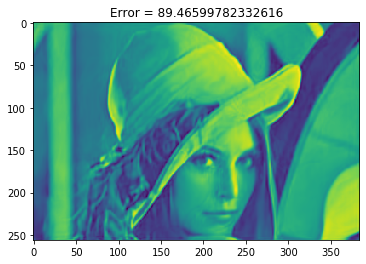

In [10]:
plt.imshow(out_img)
plt.title('Error = {}'.format(curr_error))
plt.show()

In [7]:
MAX_EPOCHS = 5000

net = EncDec1()
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)
noisy_img = torch.FloatTensor(noise1).unsqueeze(0).unsqueeze(0).transpose(2, 3)
clean_img = torch.FloatTensor(im).unsqueeze(0).unsqueeze(0).transpose(2,3)
eta = torch.randn(*noisy_img.size())

for itr in range(MAX_EPOCHS):
    out = net(eta)

    # zero the parameter gradients
    optimizer.zero_grad()
    
    # Forward + Backward + Optimize 
    loss = criterion(out, clean_img)
    loss.backward()
    optimizer.step()
    if itr % 100 == 0:
        out_img = out[0, 0, :, :].transpose(0,1).detach().numpy()
        curr_error = ((im - out_img)**2).sum()
        print ("Loss = {}, Error = {}".format(loss.detach().numpy().reshape(-1)[0], curr_error))

/home/ec2-user/anaconda3/envs/cs682/lib/python3.6/site-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/ec2-user/anaconda3/envs/cs682/lib/python3.6/site-packages/torch/nn/functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Loss = 0.44008275866508484, Error = 43261.89486129721
Loss = 0.008234234526753426, Error = 809.4581550216923
Loss = 0.004668915644288063, Error = 458.97307974456675
Loss = 0.004063126631081104, Error = 399.4216112283698
Loss = 0.0038031949661672115, Error = 373.8692785311632
Loss = 0.0037163987290114164, Error = 365.33686738021527
Loss = 0.003478381084278226, Error = 341.9387640257886
Loss = 0.003290946828201413, Error = 323.51322996112884
Loss = 0.0031708867754787207, Error = 311.71084368718584
Loss = 0.0031752362847328186, Error = 312.13842010930915
Loss = 0.0030497044790536165, Error = 299.79814463334463
Loss = 0.003005147445946932, Error = 295.41801441838237
Loss = 0.0028598993085324764, Error = 281.1395485837304
Loss = 0.0029258483555167913, Error = 287.6225899598784
Loss = 0.0029295282438397408, Error = 287.98435293488944
Loss = 0.0027430711779743433, Error = 269.6548690359591
Loss = 0.002775731962174177, Error = 272.865555365951
Loss = 0.00270037236623466, Error = 265.4573998557

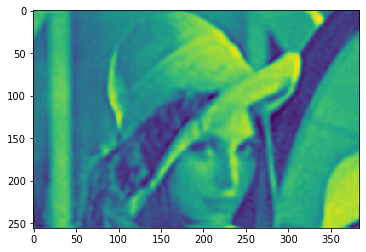

In [8]:
plt.imshow(out_img)

In [ ]:
plt.imshow(out_img)
plt.title('Error = {}'.format(curr_error))
plt.show()

In [ ]:
# Loss = 0.5038919448852539, Error = 49534.59449480633
# Loss = 0.008843245916068554, Error = 869.326449356543
# Loss = 0.004611389245837927, Error = 453.31802584668475
# Loss = 0.004262751433998346, Error = 419.04550842575935
# Loss = 0.0036459413822740316, Error = 358.4106172441831
# Loss = 0.0034898107405751944, Error = 343.06236483341377
# Loss = 0.003437972394749522, Error = 337.96644234586086
# Loss = 0.0031437904108315706, Error = 309.04716552776057
# Loss = 0.0033135905396193266, Error = 325.73919534864376
# Loss = 0.002978857373818755, Error = 292.83358722981876
# Loss = 0.003036977257579565, Error = 298.54702073586725
# Loss = 0.00292639690451324, Error = 287.6765236418348
# Loss = 0.0028691550251096487, Error = 282.049408057431
# Loss = 0.0027465694583952427, Error = 269.99877321830525
# Loss = 0.002831711433827877, Error = 278.36857199080123
# Loss = 0.002709099091589451, Error = 266.31528558754945
# Loss = 0.0027090676594525576, Error = 266.31219606732736
# Loss = 0.002634987700730562, Error = 259.0298198040908
# Loss = 0.00281581305898726, Error = 276.80569736177324
# Loss = 0.002569673117250204, Error = 252.60915357175347
# Loss = 0.002550738397985697, Error = 250.74778508447886
# Loss = 0.0026055152993649244, Error = 256.1325809752497
# Loss = 0.0024617656599730253, Error = 242.0014102911394
# Loss = 0.0024595411960035563, Error = 241.78274877444167
# Loss = 0.0025041138287633657, Error = 246.16441551166957
# Loss = 0.002492909785360098, Error = 245.063009765656
# Loss = 0.00245905970223248, Error = 241.73540789410077
# Loss = 0.00242150342091918, Error = 238.04348298530817
# Loss = 0.0024140102323144674, Error = 237.30686949171545
# Loss = 0.002383887069299817, Error = 234.34563058286824
# Loss = 0.002381108468398452, Error = 234.07247967988636
# Loss = 0.0024041126016527414, Error = 236.33389185030063
# Loss = 0.002391230780631304, Error = 235.0675557078634
# Loss = 0.002305480418726802, Error = 226.63794264142848
# Loss = 0.0023658997379243374, Error = 232.57740868097537
# Loss = 0.002279304899275303, Error = 224.06478878455692
# Loss = 0.002284661866724491, Error = 224.5913894755846
# Loss = 0.0022034088615328074, Error = 216.60390556826772
# Loss = 0.0022388785146176815, Error = 220.09072257187162
# Loss = 0.002275075763463974, Error = 223.6490527916043
# Loss = 0.0022332652006298304, Error = 219.53890000195472
# Loss = 0.0022692689672112465, Error = 223.0782162416477
# Loss = 0.0022805016487836838, Error = 224.18243615559982
# Loss = 0.002189843449741602, Error = 215.27035937186406
# Loss = 0.0022067450918257236, Error = 216.93186438758534
# Loss = 0.0021975880954414606, Error = 216.03170916967596
# Loss = 0.0022146122064441442, Error = 217.70523279731955
# Loss = 0.002211450133472681, Error = 217.3944048497108
# Loss = 0.0021457017865031958, Error = 210.93107444637528
# Loss = 0.002078321063891053, Error = 204.30726795131986